In [1]:
# Make sure that you have all these libaries available to run the code successfully
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\silva\AppData\Roaming\Python\Python36\site-

In [53]:
INPUT = 'output/\CompleteWeeklyIndexes'
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)
df_test = df.loc['2015-01-02':, 'sp500_Close'] #Selecting test data
df_train = df.loc['2000-01-01':'2015-01-01', 'sp500_Close'] #Selecting training data

In [54]:
df_train

2000-01-07    1441.469971
2000-01-14    1465.150024
2000-01-21    1441.359985
2000-01-28    1360.160034
2000-02-04    1424.369995
2000-02-11    1387.119995
2000-02-18    1346.089966
2000-02-25    1333.359985
2000-03-03    1409.170044
2000-03-10    1395.069946
2000-03-17    1464.469971
2000-03-24    1527.459961
2000-03-31    1498.579956
2000-04-07    1516.349976
2000-04-14    1356.560059
2000-04-21            NaN
2000-04-28    1452.430054
2000-05-05    1432.630005
2000-05-12    1420.959961
2000-05-19    1406.949951
2000-05-26    1378.020020
2000-06-02    1477.260010
2000-06-09    1456.949951
2000-06-16    1464.459961
2000-06-23    1441.479980
2000-06-30    1454.599976
2000-07-07    1478.900024
2000-07-14    1509.979980
2000-07-21    1480.189941
2000-07-28    1419.890015
                 ...     
2014-06-06    1949.439941
2014-06-13    1936.160034
2014-06-20    1962.869995
2014-06-27    1960.959961
2014-07-04            NaN
2014-07-11    1967.569946
2014-07-18    1978.219971
2014-07-25  

In [76]:
type(df_test.values.reshape((-1, 1)))

numpy.ndarray

In [78]:
scaler = MinMaxScaler()
scaler.fit(df_train.values.reshape((-1, 1)))
train_data = scaler.transform(df_train.values.reshape((-1, 1)))
test_data = scaler.transform(df_test.values.reshape((-1, 1)))
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [79]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))


for i in range(train_data.shape[1]):
    dg = DataGeneratorSeq(train_data[:,i],10,10)
    u_data, u_labels = dg.unroll_batches()

    for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
        print('\n\nUnrolled index %d'%ui)
        dat_ind = dat
        lbl_ind = lbl
        print('\tInputs: ',dat )
        print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.5394161  0.38494653 0.1511182         nan 0.41390643 0.59225553
 0.13512973 0.30418602 0.42814445 0.6203758 ]

	Output: [0.5393378  0.37531927 0.16024734 0.32094297 0.4164538  0.6044799
 0.08300189 0.2714549  0.41303122 0.70022553]


Unrolled index 1
	Inputs:  [0.55626553 0.36090335 0.13663113 0.32136276 0.40984353 0.6069205
 0.08300189 0.32183242 0.4054746  0.6395804 ]

	Output: [0.50074357 0.3717402  0.12666948 0.30555934 0.41550028 0.58344656
 0.1397121  0.28890914 0.33819085 0.70022553]


Unrolled index 2
	Inputs:  [0.5393378  0.3787561  0.16024734 0.32094297 0.41550028 0.5865205
 0.15145972 0.28768522 0.41303122 0.662478  ]

	Output: [0.4715488  0.3717402  0.15540172 0.28662503 0.40195963 0.58344656
 0.13710785 0.29046738 0.37873474 0.6875102 ]


Unrolled index 3
	Inputs:  [0.4815603  0.37531927 0.17375249 0.31450343 0.4164538  0.6044799
 0.13710785 0.28890914 0.37873474 0.6761966 ]

	Output: [0.46249083 0.3778097  0.10410633 0.28662503 0.4284006  0

In [80]:
len(train_data[:,0])

782

In [81]:
train_data.shape[1]

1

In [97]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 10 # Number of time steps you look into the future.
batch_size = 100 # Number of samples in a batch
num_nodes = [100,100,50] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.1 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [98]:
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [99]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [100]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [101]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [102]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [103]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 10 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator

data_gen = DataGeneratorSeq(train_data[:,i],batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(782,782,10).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

        # The average loss
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)

        average_loss = 0 # reset loss

        predictions_seq = []

        mse_test_loss_seq = []

        # ===================== Updating State and Making Predicitons ========================
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []

            if (ep+1)-valid_summary==0:
              # Only calculate x_axis values in the first validation epoch
              x_axis=[]

            # Feed in the recent past behavior of stock prices
            # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1,w_i-1):
                current_price = all_mid_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
                _ = session.run(sample_prediction,feed_dict=feed_dict)

            feed_dict = {}

            current_price = all_mid_data[w_i-1]

            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

            # Make predictions for this many steps
            # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):

                pred = session.run(sample_prediction,feed_dict=feed_dict)

                our_predictions.append(np.asscalar(pred))

                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                if (ep+1)-valid_summary==0:
                    # Only calculate x_axis values in the first validation epoch
                    x_axis.append(w_i+pred_i)

                mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

            session.run(reset_sample_states)

            predictions_seq.append(np.array(our_predictions))

            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if (ep+1)-valid_summary==0:
                x_axis_seq.append(x_axis)

            current_test_mse = np.mean(mse_test_loss_seq)

            # Learning rate decay logic
            if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
                loss_nondecrease_count += 1
            else:
                loss_nondecrease_count = 0

            if loss_nondecrease_count > loss_nondecrease_threshold :
                session.run(inc_gstep)
                loss_nondecrease_count = 0
                print('\tDecreasing learning rate by 0.5')

            test_mse_ot.append(current_test_mse)
            print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
            predictions_over_time.append(predictions_seq)
            print('\tFinished Predictions')

Initialized
Average loss at step 1: nan
Average loss at step 2: nan
Average loss at step 3: nan
Average loss at step 4: nan
Average loss at step 5: nan
Average loss at step 6: nan
Average loss at step 7: nan
Average loss at step 8: nan
Average loss at step 9: nan
Average loss at step 10: nan
Average loss at step 11: nan
Average loss at step 12: nan
Average loss at step 13: nan
Average loss at step 14: nan
Average loss at step 15: nan
Average loss at step 16: nan
Average loss at step 17: nan
Average loss at step 18: nan
Average loss at step 19: nan
Average loss at step 20: nan
Average loss at step 21: nan
Average loss at step 22: nan
Average loss at step 23: nan
Average loss at step 24: nan
Average loss at step 25: nan
Average loss at step 26: nan
Average loss at step 27: nan
Average loss at step 28: nan
Average loss at step 29: nan
Average loss at step 30: nan


ZeroDivisionError: float division by zero

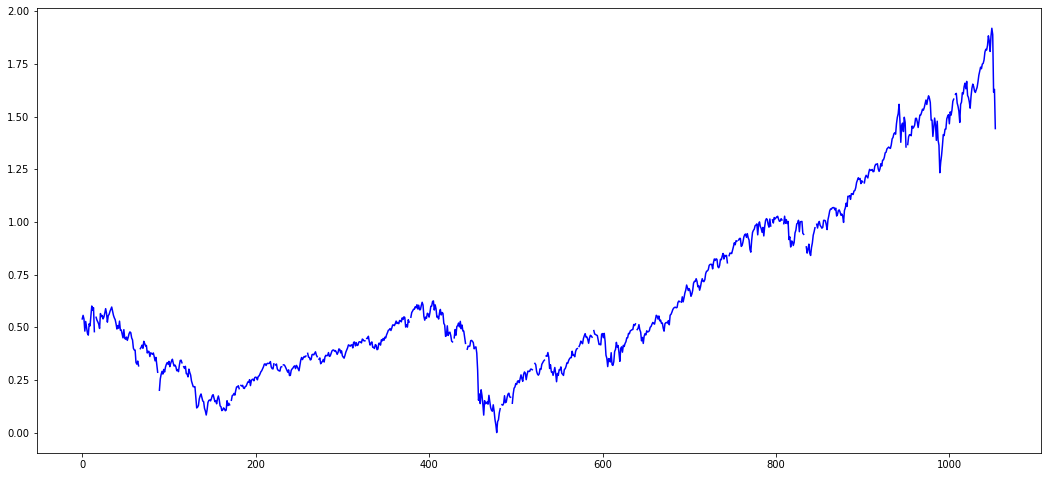

In [104]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()